# Import Libraries

In [1]:
!pip install -q opendatasets

import opendatasets as od

od.download('https://www.kaggle.com/c/digit-recognizer/data') # insert ypu kaggle  username and key
#username: aidankim0510
#key: 01ed098689c2156e31cbc723fa2e1517

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aidankim0510
Your Kaggle Key: ··········


100%|██████████| 15.3M/15.3M [00:01<00:00, 12.6MB/s]



Extracting archive ./digit-recognizer/digit-recognizer.zip to ./digit-recognizer


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')


# Load Data / Exploration

In [4]:
train = pd.read_csv('/content/digit-recognizer/train.csv')
test = pd.read_csv('/content/digit-recognizer/test.csv')

In [5]:
train.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
Y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)

g = Y_train.value_counts()
g

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

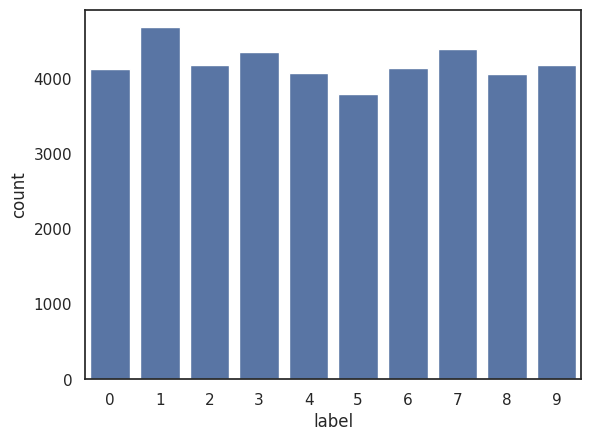

In [8]:
sns.countplot(x=Y_train)

In [9]:
#checking for null values
print(X_train.isnull().any().count())
print(test.isnull().any().count())

784
784


In [10]:
#normalizing the data
X_train = X_train / 255.0
test = test / 255.0

In [11]:
#Reshaping the data
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [12]:
#Encoding labels to one hot
Y_train = to_categorical(Y_train, num_classes = 10)

# Preview Image

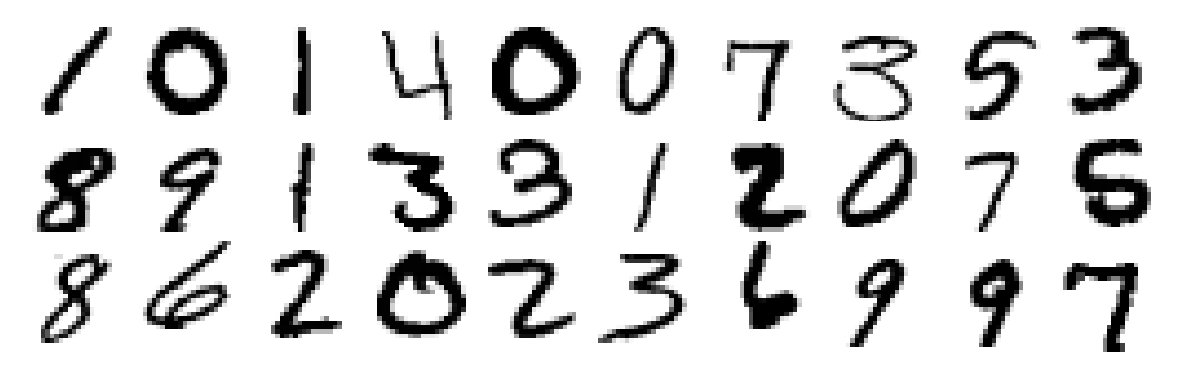

In [13]:
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# Train / Validation

In [14]:
random_seed = 2

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

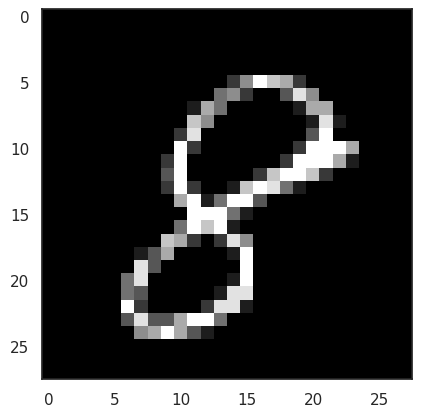

In [16]:
expimg = plt.imshow(X_train[0][:,:,0], cmap="gray")

# CNN Model

In [17]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=(5,5), padding='same',
                 activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters = 32, kernel_size=(5,5), padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [18]:
#Define the optimizer
optimizer = RMSprop(learning_rate=0.001,
                    rho=0.9,
                    epsilon=1e-08,
                    weight_decay=0.0)

In [19]:
#Compile the model
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [20]:
#Learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [21]:
epochs = 1
batch_size = 86

In [22]:
#Data augmentation
datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.10,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
datagen.fit(X_train)

In [23]:
#using model.fit_generator() since there is data augmentation
history = model.fit(datagen.flow(X_train, Y_train, batch_size = batch_size),
                              epochs=epochs,
                              validation_data=(X_val, Y_val),
                              verbose=2,
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

439/439 - 273s - loss: 0.4235 - accuracy: 0.8627 - val_loss: 0.0994 - val_accuracy: 0.9707 - lr: 0.0010 - 273s/epoch - 622ms/step


# Evaluating the Model

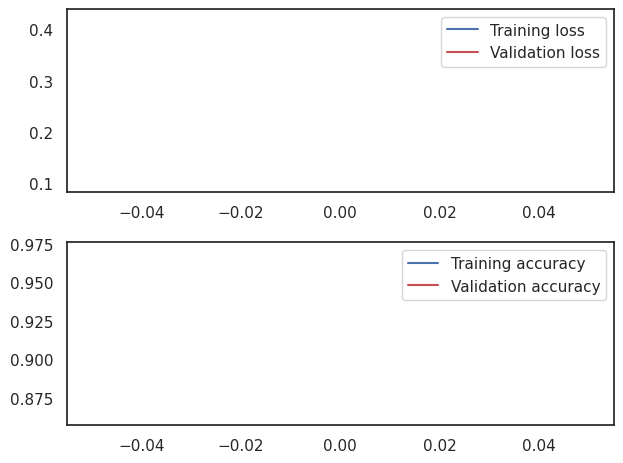

In [24]:
#Graphical representation of the loss and accuracy curves for training and validation

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best')

plt.tight_layout()

In [25]:
#Confusion matrix function

def plt_cm(cm, classes,
           normalize=False,
           title='Confusion matrix',
           cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment = "center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


132/132 [==============================] - 7s 50ms/step


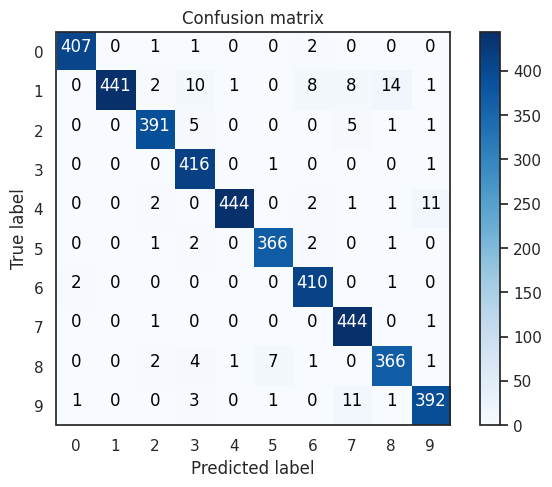

In [26]:
#Plotting the cm

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plt_cm(confusion_mtx, classes = range(10))

# Analyzing Errors

In [27]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

#showing 6 images of errors
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
  n = 0
  nrows = 2
  ncols = 3
  fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
  for row in range(nrows):
    for col in range(ncols):
      error = errors_index[n]
      ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap="gray")
      ax[row,col].set_title("Predicted label :{}\nTrue label :{}".
                            format(pred_errors[error], obs_errors[error]))
      n += 1

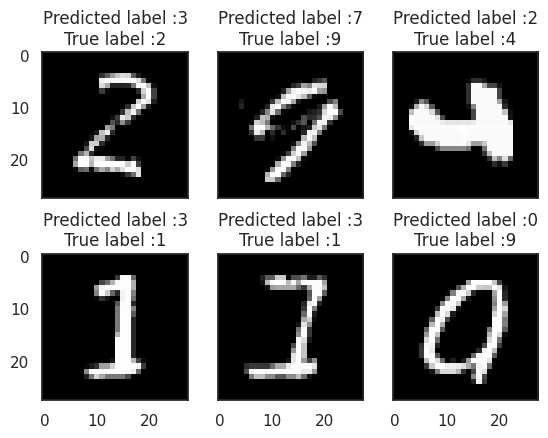

In [28]:
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors,
                                       axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_delta_errors[-6:]

display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors,
               Y_true_errors)

In [29]:
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")
results

875/875 [==============================] - 51s 58ms/step


0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [30]:
end_result = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
end_result

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
